BASIC SIMULATION ANALYSIS

In [1]:
# Import dependencies
import sys, pkgutil, os
import importlib

%load_ext autoreload
%autoreload 2

print(sys.executable)  # should point to .venv/bin/python

import cosmo_analysis
print("cosmo_analysis import OK; file:", cosmo_analysis.__file__)
print("submodules:", [m.name for m in pkgutil.iter_modules(cosmo_analysis.__path__)])

/sqfs/work/hp240141/z6b616/cosmo_analysis/.venv/bin/python
cosmo_analysis import OK; file: /sqfs2/cmc/1/work/hp240141/z6b616/cosmo_analysis/src/cosmo_analysis/__init__.py
submodules: ['core', 'io', 'plot']


In [2]:
def list_submodules_recursive(package, prefix=''):
    """
    Recursively discovers and lists all submodules for a given package.
    """
    # The prefix for iter_modules should be the package name + '.'
    module_prefix = package.__name__ + '.'
    
    # Find all direct submodules
    for module_info in pkgutil.iter_modules(package.__path__, prefix=module_prefix):
        # Print the found submodule
        print(prefix + module_info.name)
        
        # If the submodule is a package itself, recurse into it
        if module_info.ispkg:
            try:
                # Import the sub-package to access its __path__
                sub_package = importlib.import_module(module_info.name)
                # Recurse with increased indentation
                list_submodules_recursive(sub_package, prefix=prefix + "  ")
            except ImportError as e:
                print(f"{prefix}  -> Error importing {module_info.name}: {e}")

# Start the process from the top-level 'cosmo_analysis' package
print(f"Submodule tree for '{cosmo_analysis.__name__}':")
list_submodules_recursive(cosmo_analysis)

Submodule tree for 'cosmo_analysis':
cosmo_analysis.core
  cosmo_analysis.core.constants
  cosmo_analysis.core.fields
  cosmo_analysis.core.sim_objs
  cosmo_analysis.core.sim_prop
  cosmo_analysis.core.utils
cosmo_analysis.io
  cosmo_analysis.io.load
cosmo_analysis.plot
  cosmo_analysis.plot.plots


In [11]:
from cosmo_analysis.io.load import load 
from cosmo_analysis.plot.plots import ytProjPanel

# Load simulation and generate projection plots
sim_path = "/sqfs/work/hp240141/z6b616/sims/arepoIso/cal1"
sim = load(name="cal1", path=sim_path, centerDefs=["3", "7"], allowedSnaps=[5])


In [18]:
from cosmo_analysis.plot.workflows import NSFFanalysis

NSFFanalysis(simsNS=[sim], idxNS=[0], saveFigPath="/sqfs/work/hp240141/z6b616/analysis/arepoIsoCal1", extraText="TestRun")

#ytProjPanel(simArr=[sim], idxArr=[0], part="PartType0", message="Gas Density Projection", showFig=True, saveFig=False)
#ytProjPanel(simArr=[sim], idxArr=[0], part="PartType1", message="Dark Matter Density Projection", showFig=True, saveFig=False)

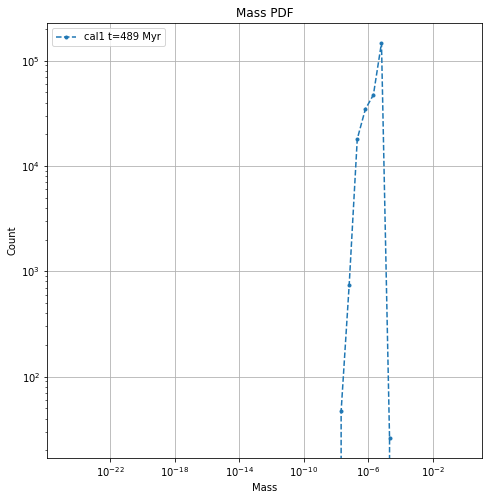

In [22]:
from cosmo_analysis.plot.plots import plotBinned

plotBinned([sim],[0],("Masses","particle_ones"),50,(1e-25,1e0),message="Mass PDF",spLim=30,setLogs=(True,True),
           setUnits=(0,0),xlims=0,ylims=0,plotTitle="Mass PDF", saveFig=False, showFig=True,
           xylabels=("Mass","Count"))

In [54]:
# Imports for DM analysis
from cosmo_analysis.io.load import load
from cosmo_analysis.plot.plots import ytProjPanel, plotBinned, binFunctionSphVol
from cosmo_analysis.core.constants import dmPart

# --- DM-Only Simulation Analysis ---

# 1. Load the DM-only simulation
# !!! IMPORTANT: Replace with the actual path to your DM-only simulation !!!
sim_path_dm = "/sqfs/work/hp240141/z6b616/sims/AGORAdwarf/DMonly/" 
sim_dm = load(name="dwarf_dm_only", path=sim_path_dm, centerDefs=["3", "8"],snapFilename="snap")


Initializing refined index: 100%|██████████| 13/13 [00:01<00:00,  7.99it/s]

Initializing refined index: 100%|██████████| 13/13 [00:01<00:00,  8.17it/s]

Initializing refined index: 100%|██████████| 13/13 [00:01<00:00,  9.02it/s]

Initializing refined index: 100%|██████████| 13/13 [00:01<00:00,  8.91it/s]

Initializing refined index: 100%|██████████| 13/13 [00:01<00:00,  8.95it/s]

/sqfs/work/hp240141/z6b616/cosmo_analysis/.venv/lib64/python3.6/site-packages/unyt/array.py:1779: RuntimeWarning: invalid value encountered in true_divide
  inp0.view(np.ndarray), inp1.view(np.ndarray), out=out_func, **kwargs
/sqfs/work/hp240141/z6b616/cosmo_analysis/.venv/lib64/python3.6/site-packages/unyt/array.py:1779: RuntimeWarning: invalid value encountered in true_divide
  inp0.view(np.ndarray), inp1.view(np.ndarray), out=out_func, **kwargs
Initializing refined index: 100%|██████████| 13/13 [00:01<00:00,  8.53it/s]

Initializing refined index: 100%|██████████| 13/13 [00:01<00:00,  8.21it/s]

Initializ

1.8515311817741664



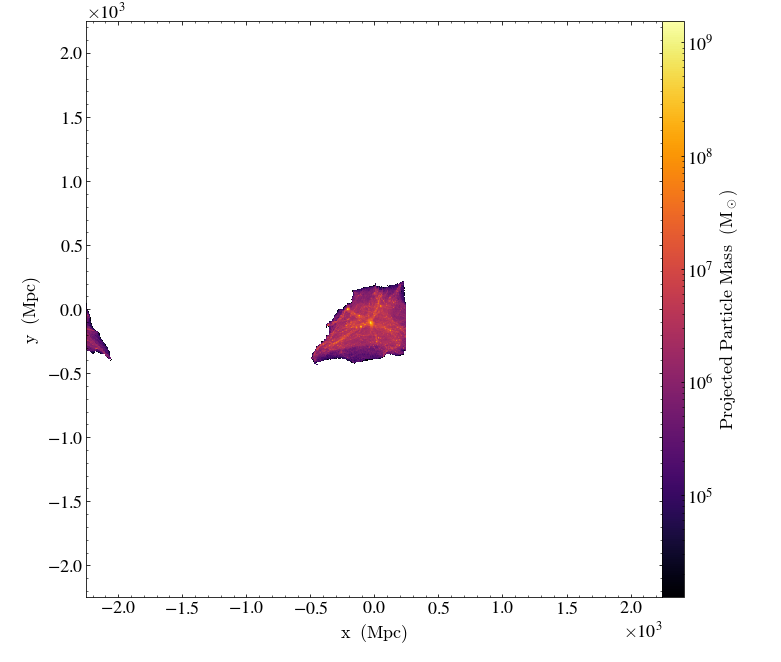

In [86]:
# Fixed DM projection + spherical profile (handles MassTable fallback)
import yt, numpy as np, matplotlib.pyplot as plt
from yt.visualization.particle_plots import ParticlePhasePlot

# ---------- user params ----------
ds = sim_dm.ytFull[-1]
center = ds.arr(sim_dm.snap[-1].center, "Mpc")
box_width = 5.0   # Mpc
nbins_2d = 512
nbins_radial = 50
# ----------------------------------

print(sim_dm.snap[-1].z)
# create our plot
p = yt.ParticlePlot(
    ds,
    ("PartType1", "particle_position_x"),
    ("PartType1", "particle_position_y"),
    ("PartType1", "particle_mass"),
    width=(9000, 9000)
)

# pick some appropriate units
p.set_axes_unit("Mpc")
p.set_cmap(("PartType1", "particle_mass"),"inferno")
p.set_unit(("PartType1", "particle_mass"), "Msun")

2.078089546545675


In [ ]:
# Imports for movie creation
from cosmo_analysis.core.constants import savePath
from cosmo_analysis.plot.plots import makeMovie, saveFrame
import yt
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import io
from PIL import Image
import numpy as np

# --- Dark Matter Particle Movie ---

# 1. Define a function to create a single frame
def create_dm_frame(ds):
    """Creates a single frame for the dark matter movie."""
    
    # Create the particle plot
    p = yt.ParticlePlot(
        ds,
        ("all", "particle_position_x"),
        ("all", "particle_position_y"),
        ("all", "particle_mass"),
        width=(500000, "kpc")
    )
    
    # Set units and colormap
    p.set_axes_unit("Mpc")
    p.set_cmap(("all", "particle_mass"), "plasma")
    p.set_unit(("all", "particle_mass"), "Msun")
    
    # Add redshift annotation
    p.annotate_timestamp(corner="lower_left",
    time=True,
    redshift=True,                    
    time_unit="Gyr",                  
    time_format="t = {time:.2f} {units}",  # e.g. "t = 0.32 Gyr"
    draw_inset_box=False,
    text_args={"color":"white", "fontsize":12, "horizontalalignment":"left", "verticalalignment":"bottom"})

    p._setup_plots()

    # Force the plot to be drawn to get the figure handle
    plot = p.plots[('all', 'particle_mass')]
    fig = plot.figure
    
    # Use the saveFrame function from the library
    frame = saveFrame(fig, verbose=0)
    return frame

# 2. Generate frames for the movie
# Note: This can be time and memory intensive. 
# We will just generate it for a few snapshots as an example.
num_frames_to_generate = 1000
frames = []
for i in range(min(num_frames_to_generate, len(sim_dm.ytFull))):
    print(f"Generating frame {i+1}/{min(num_frames_to_generate, len(sim_dm.ytFull))}...")
    ds = sim_dm.ytFull[i]
    frames.append(create_dm_frame(ds))

# 3. Create the movie
# Set saveFigPath to a directory if you want to save the movie file.
# For example: saveFigPath="/sqfs/work/hp240141/z6b616/analysis/arepoIsoCal1"
print("Compiling movie...")
makeMovie(frames, saveFigPath=0, message="dm_particle_evolution")
print("Movie generation complete. It should be displayed below if not saving to a file.")


Generating frame 1/210...
Generating frame 2/210...
Generating frame 2/210...
Generating frame 3/210...
Generating frame 3/210...
Generating frame 4/210...
Generating frame 4/210...
Generating frame 5/210...
Generating frame 5/210...
Generating frame 6/210...
Generating frame 6/210...
Generating frame 7/210...
Generating frame 7/210...
Generating frame 8/210...
Generating frame 8/210...
Generating frame 9/210...
Generating frame 9/210...
Generating frame 10/210...
Generating frame 10/210...
Generating frame 11/210...
Generating frame 11/210...
Generating frame 12/210...
Generating frame 12/210...
Generating frame 13/210...
Generating frame 13/210...
Generating frame 14/210...
Generating frame 14/210...
Generating frame 15/210...
Generating frame 15/210...
Generating frame 16/210...
Generating frame 16/210...
Generating frame 17/210...
Generating frame 17/210...
Generating frame 18/210...
Generating frame 18/210...
Generating frame 19/210...
Generating frame 19/210...
Generating frame 2

MovieWriter ffmpeg unavailable; using Pillow instead.
